In [2]:

import pandas as pd
import numpy as np

import folium
import io
import os

import pathlib

import requests
import seaborn as sns
import scipy.odr as odr
import statsmodels.api as sm

import scipy
import scipy.optimize as op
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy import stats

#from pandas.stats.api import ols
from datetime import date, timedelta
import datetime

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy.optimize import curve_fit

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib
import matplotlib as mpl
import matplotlib.cm as cm
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
rcParams['pdf.fonttype'] = 42
inline_rc = dict(plt.rcParams)

#from matplotlib.pyplot import cm 
import platform
import sys
import glob
import time
import folium
import random
import pymannkendall as mk
#import windrose
#from windrose import WindroseAxes

import geopandas as gpd
#import geemap

from functools import reduce

from contextlib import closing
import csv

import pyproj
from pyproj import Proj

import math
import ee
import openet.refetgee

import pathlib

#import spotpy
#import simplekml

In [3]:
print("Operating System " + platform.system() + " " + platform.release())
print("Python Version " + str(sys.version))
print("Pandas Version " + str(pd.__version__))
print("Numpy Version " + str(np.__version__))
print("Matplotlib Version " + str(mpl.__version__))
#print("Well Application Version " + str(wa.__version__))
print("Scipy Version " +str(scipy.__version__))
print (os.environ['CONDA_DEFAULT_ENV'])


Operating System Windows 11
Python Version 3.12.6 | packaged by conda-forge | (main, Sep 30 2024, 17:48:58) [MSC v.1941 64 bit (AMD64)]
Pandas Version 2.2.2
Numpy Version 2.0.2
Matplotlib Version 3.9.2
Scipy Version 1.14.1
pygis12


In [4]:
station_info = gpd.read_file('station_info.gpkg', driver='GPKG', layer='stations')
station_info['station_id'] = station_info['station_id'].astype(np.int32)
station_info = station_info.set_index(['station_id'])

well = pd.DataFrame({'primary_id':'US-UTW','network':'UFN','latitude':39.4453,'longitude': -110.7288,'name':'Wellington'},index=[1682])
well.index.name = 'station_id'

well_gdf = gpd.GeoDataFrame(well,geometry=gpd.points_from_xy(well['longitude'],well['latitude'],crs='WGS 84'))

studystats = pd.concat([station_info,well_gdf],axis=0)

C:\Users\paulinkenbrandt\Anaconda3\envs\pygis12\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver GPKG does not support open option DRIVER
  return ogr_read(


In [5]:
studystats

,primary_id,name,latitude,longitude,elevation,network,geometry
station_id,,,,,,,
1294660,BUFU1,Buck Flat,39.134,-111.43722,9409,SNOTEL,POINT (-111.43722 39.134)
1294691,GBMU1,GBRC Meadows,39.30229,-111.45383,9858,SNOTEL,POINT (-111.45383 39.30229)
1294704,HNHU1,Huntington Horse,39.61774,-111.30576,9652,SNOTEL,POINT (-111.30576 39.61774)
1294727,MCDU1,Mammoth-Cottonwood,39.68338,-111.31818,8709,SNOTEL,POINT (-111.31818 39.68338)
1294734,MTBU1,Mt Baldy,39.13648,-111.50527,9524,SNOTEL,POINT (-111.50527 39.13648)
1294744,RPRU1,Red Pine Ridge,39.45197,-111.27221,8988,SNOTEL,POINT (-111.27221 39.45197)
1294750,SEEU1,Seeley Creek,39.31042,-111.43297,9904,SNOTEL,POINT (-111.43297 39.31042)
1294768,UJVU1,Upper Joes Valley,39.4155,-111.2491,8596,SNOTEL,POINT (-111.2491 39.4155)
1294775,WRIU1,Wrigley Creek,39.13233,-111.35685,9327,SNOTEL,POINT (-111.35685 39.13233)


In [6]:
# OpenStreetMap
map = folium.Map(location=[np.mean(studystats.geometry.y), np.mean(studystats.geometry.x)], tiles="OpenStreetMap", zoom_start=9)

# Create a geometry list from the GeoDataFrame
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in studystats.geometry]

# Iterate through list and add a marker for each volcano, color-coded by its type.
i = 0
for coordinates in geo_df_list:
    # assign a color marker for the type of volcano, Strato being the most common
    if studystats.iloc[i]['network'] == 'SNOTEL':
        type_color = "green"
    elif studystats.iloc[i]['network'] == 'UAGRIMET':
        type_color = "blue"
    elif studystats.iloc[i]['network'] == 'mesowest':
        type_color = "pink"
    else:
        type_color = "purple"
    # Place the markers with the popup labels and data
    map.add_child(
        folium.Marker(
            location=coordinates,
            popup="Name: "
            + str(studystats.iloc[i]['name'])
            + "<br>"
            + "Network: "
            + str(studystats.iloc[i]['network'])
            + "<br>"
            + "Coordinates: "
            + str(geo_df_list[i]),
            icon=folium.Icon(color="%s" % type_color),
        )
    )
    i = i + 1

map

In [10]:
gridmet = pd.read_parquet("gridmet_weather_station_data.parquet") #daily
gpm = pd.read_parquet("gpm_weather_station_data.parquet") #monthly
nldas = pd.read_parquet("nlads_weather_station_data.parquet") #hourly
modet= pd.read_parquet("modiset_weather_station_data.parquet") #dailyish
daymet = pd.read_parquet("daymet_weather_station_data.parquet") #daily
terra = pd.read_parquet("terraclimate_weather_station_data.parquet") #monthly

nldas_dly = pd.read_parquet("nlads_daily_weather_station_data.parquet")

grid = gridmet.set_index(['stationid','Timestamp'])[['eto','etr','pr']]
grid.columns = pd.MultiIndex.from_product([['gridmet'],grid.columns])


daym = daymet.set_index(['stationid','Timestamp'])[['sw','pr','swe']]
daym.columns = pd.MultiIndex.from_product([['daymet'],daym.columns])

nld_dly = nldas_dly.set_index(['stationid','Timestamp'])[['lw','sw','pr','pet']]
nld_dly.columns = pd.MultiIndex.from_product([['nldas'],nld_dly.columns])

daily = pd.concat([daym, grid, nld_dly], axis=1)
        
#gee_daily = pd.concat([gridmet,daymet,nldas_dly],axis=1)

#more_mo = gee_daily[['eto','etr','pr','swe','pet','Timestamp','stationid','datasource']].groupby(['stationid','datasource',pd.Grouper(key='Timestamp',freq='1MS')]).sum().reset_index()
more_mo = daily.stack(0, future_stack=True).reset_index().rename(columns={'level_2':'datasource'})[['eto','etr','pr','swe','pet','Timestamp','stationid','datasource']].groupby(['stationid','datasource',pd.Grouper(key='Timestamp',freq='1MS')]).sum().reset_index()
gee_monthly = pd.concat([modet, gpm, terra, more_mo],axis=0)

(17532.0, 19631.0)

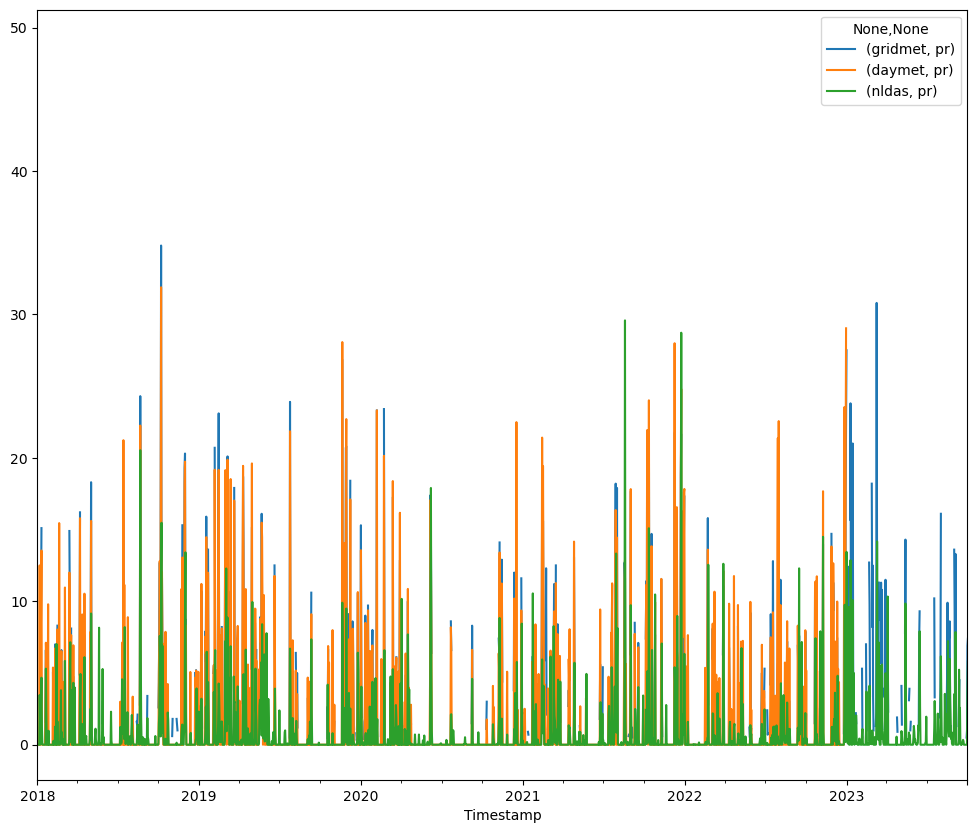

In [11]:
daily[[['gridmet','pr'],['daymet','pr'],['nldas','pr']]].loc[1294660].sort_index().plot()
plt.xlim('2018-01-01','2023-10-01')

<Axes: xlabel='Timestamp'>

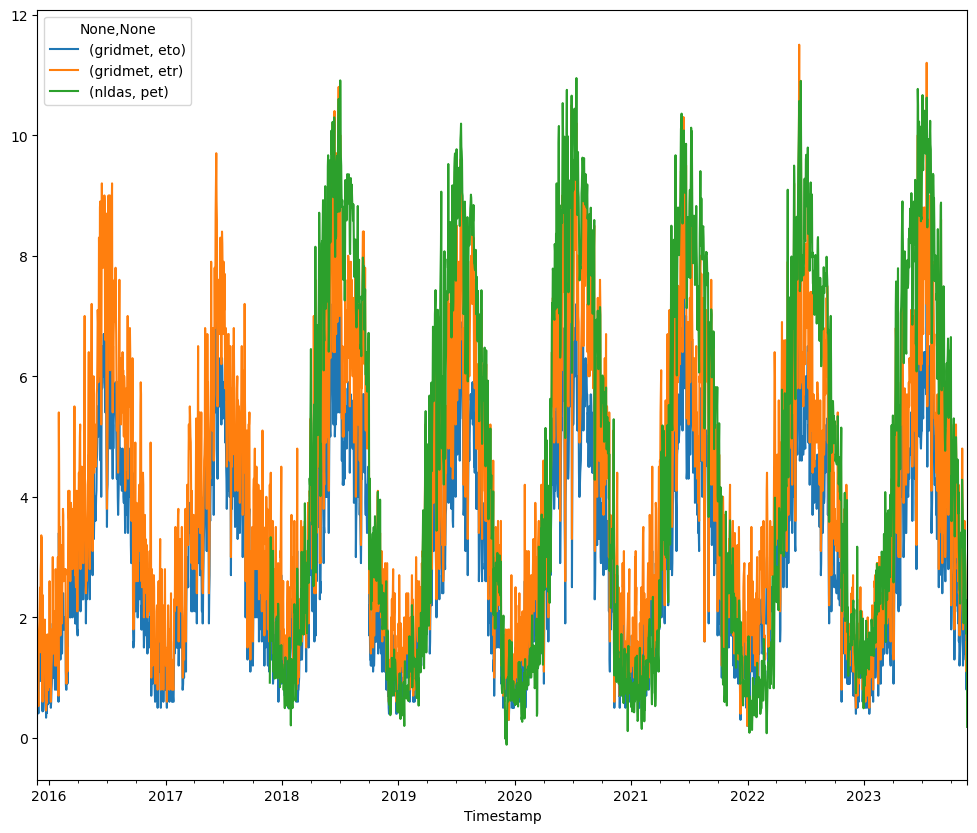

In [14]:
daily[[['gridmet','eto'],['gridmet','etr'],['nldas','pet']]].loc[1294660].sort_index().plot()

<Axes: xlabel='Timestamp'>

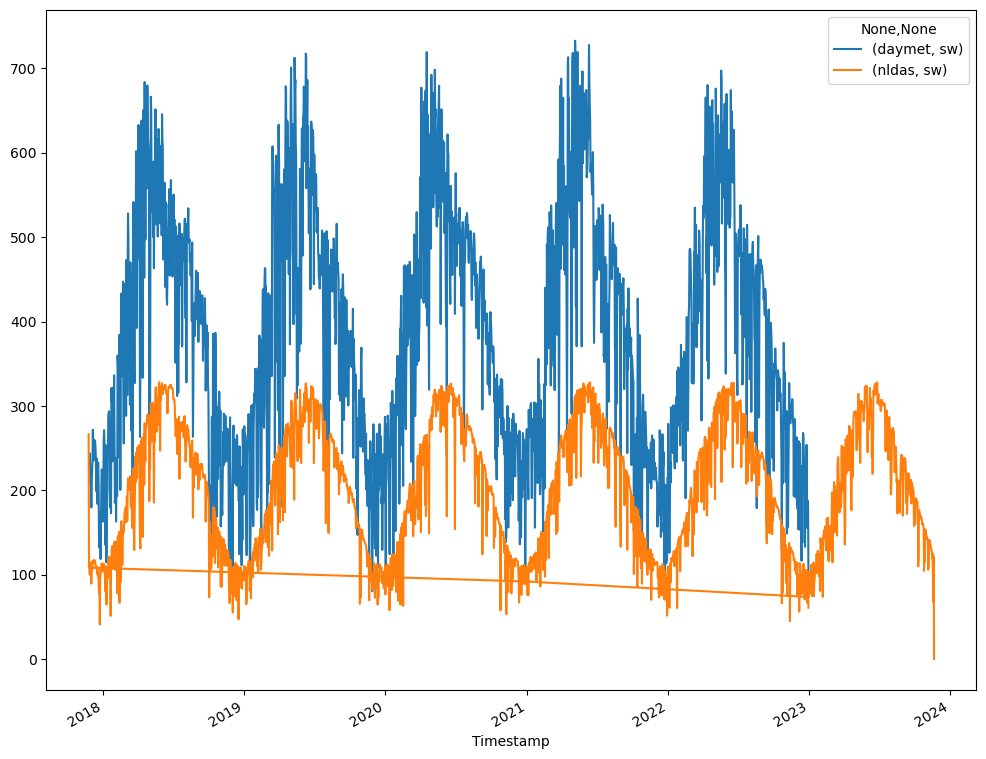

In [15]:
daily[[['daymet','sw'],['nldas','sw']]].loc[1294660].sort_index().plot()

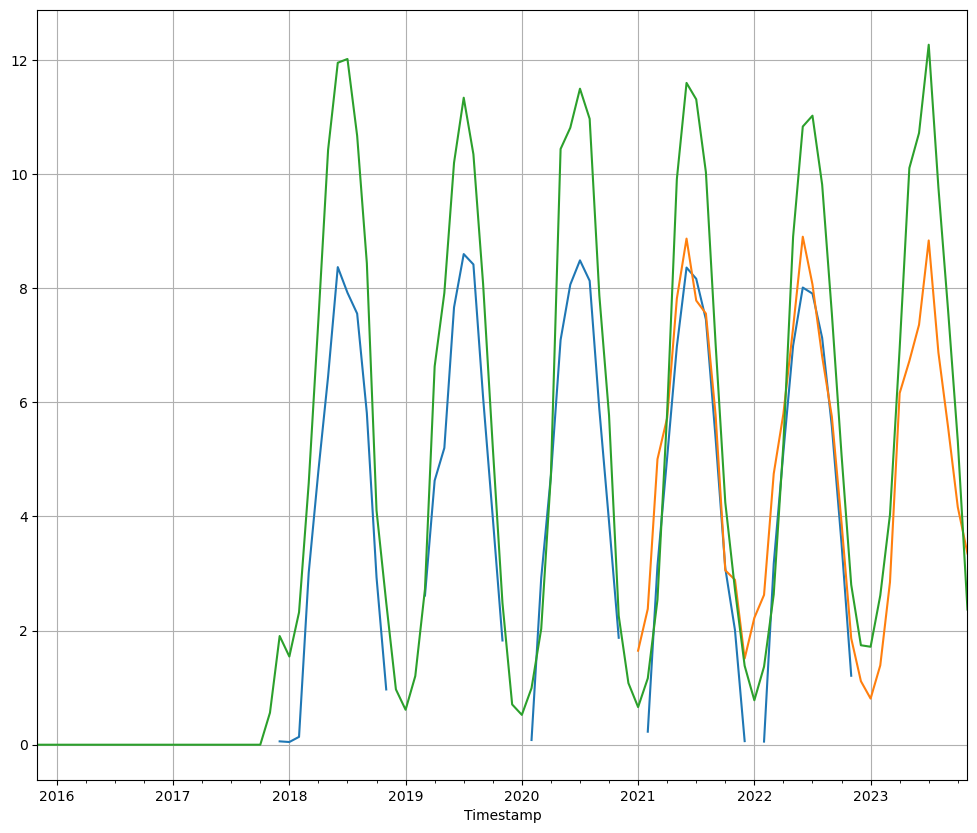

In [16]:
pet_mo = gee_monthly[['Timestamp','datasource','stationid','pet']].set_index(['stationid','Timestamp','datasource']).unstack(level=-1).droplevel(axis=1,level=0).loc[1266805]
pet_mo = pet_mo*0.0393701 #convert to inches
pet_mo['terra'].plot()
pet_mo['MODIS'].plot()
pet_mo['nldas'].plot()
plt.grid()

In [17]:
monthly = gee_monthly.set_index(['stationid','Timestamp','datasource']).stack().unstack(-2).unstack(-1).dropna(axis=1,how='all')

In [18]:
monthly.columns

MultiIndex([(  'MODIS',           'aet'),
            (  'MODIS',            'le'),
            (  'MODIS',           'pet'),
            (  'MODIS',           'ple'),
            (  'MODIS', 'days_in_month'),
            ( 'daymet',           'pet'),
            ( 'daymet',            'pr'),
            ( 'daymet',           'swe'),
            ( 'daymet',           'eto'),
            ( 'daymet',           'etr'),
            (    'gpm',            'pr'),
            (    'gpm',       'prob_pr'),
            ('gridmet',           'pet'),
            ('gridmet',            'pr'),
            ('gridmet',           'swe'),
            ('gridmet',           'eto'),
            ('gridmet',           'etr'),
            (  'nldas',           'pet'),
            (  'nldas',            'pr'),
            (  'nldas',           'swe'),
            (  'nldas',           'eto'),
            (  'nldas',           'etr'),
            (  'terra',           'aet'),
            (  'terra',           

In [19]:
monthly #[['eto', 'etr', 'pr', 'pet',  'swe', 'stationid', 'Timestamp']]

datasource                MODIS                                     \
                            aet          le        pet         ple   
stationid Timestamp                                                  
1         2015-11-01        NaN         NaN        NaN         NaN   
          2015-12-01        NaN         NaN        NaN         NaN   
          2016-01-01        NaN         NaN        NaN         NaN   
          2016-02-01        NaN         NaN        NaN         NaN   
          2016-03-01        NaN         NaN        NaN         NaN   
...                         ...         ...        ...         ...   
1294775   2023-07-01  66.843750  204.115625  258.07500  789.240625   
          2023-08-01  48.437500  148.412500  194.13750  595.587500   
          2023-09-01  26.812500   82.593750  173.90625  535.312500   
          2023-10-01  14.466667   45.466667  145.31250  449.112500   
          2023-11-01  12.000000   36.750000  126.37500  391.500000   

datasource                         daymet                      ... nldas       \
                     days_in_month    pet   pr  swe  eto  etr  ...   eto  etr   
stationid Timestamp                                            ...              
1         2015-11-01           NaN    0.0  0.0  0.0  0.0  0.0  ...   0.0  0.0   
          2015-12-01           NaN    0.0  0.0  0.0  0.0  0.0  ...   0.0  0.0   
          2016-01-01           NaN    0.0  0.0  0.0  0.0  0.0  ...   0.0  0.0   
          2016-02-01           NaN    0.0  0.0  0.0  0.0  0.0  ...   0.0  0.0   
          2016-03-01           NaN    0.0  0.0  0.0  0.0  0.0  ...   0.0  0.0   
...                            ...    ...  ...  ...  ...  ...  ...   ...  ...   
1294775   2023-07-01          31.0    0.0  0.0  0.0  0.0  0.0  ...   0.0  0.0   
          2023-08-01          31.0    0.0  0.0  0.0  0.0  0.0  ...   0.0  0.0   
          2023-09-01          30.0    0.0  0.0  0.0  0.0  0.0  ...   0.0  0.0   
          2023-10-01          31.0    0.0  0.0  0.0  0.0  0.0  ...   0.0  0.0   
          2023-11-01          30.0    0.0  0.0  0.0  0.0  0.0  ...   0.0  0.0   

datasource           terra                               
                       aet pet  pr def  ro soil  sw swe  
stationid Timestamp                                      
1         2015-11-01   NaN NaN NaN NaN NaN  NaN NaN NaN  
          2015-12-01   NaN NaN NaN NaN NaN  NaN NaN NaN  
          2016-01-01   NaN NaN NaN NaN NaN  NaN NaN NaN  
          2016-02-01   NaN NaN NaN NaN NaN  NaN NaN NaN  
          2016-03-01   NaN NaN NaN NaN NaN  NaN NaN NaN  
...                    ...  ..  ..  ..  ..  ...  ..  ..  
1294775   2023-07-01   NaN NaN NaN NaN NaN  NaN NaN NaN  
          2023-08-01   NaN NaN NaN NaN NaN  NaN NaN NaN  
          2023-09-01   NaN NaN NaN NaN NaN  NaN NaN NaN  
          2023-10-01   NaN NaN NaN NaN NaN  NaN NaN NaN  
          2023-11-01   NaN NaN NaN NaN NaN  NaN NaN NaN  

[1843 rows x 30 columns]

In [21]:
snotel = pd.read_parquet('snotel.parquet')
mesodata = pd.read_parquet('meso.parquet')
agstationdata = pd.read_parquet('agstdata.parquet')
agrimet_hrly = pd.read_parquet('agrimet_hrly.parquet')
agrimet_dly = pd.read_parquet('agrimet_dly.parquet')

In [22]:
df

NameError: name 'df' is not defined

<Axes: xlabel='date_time'>

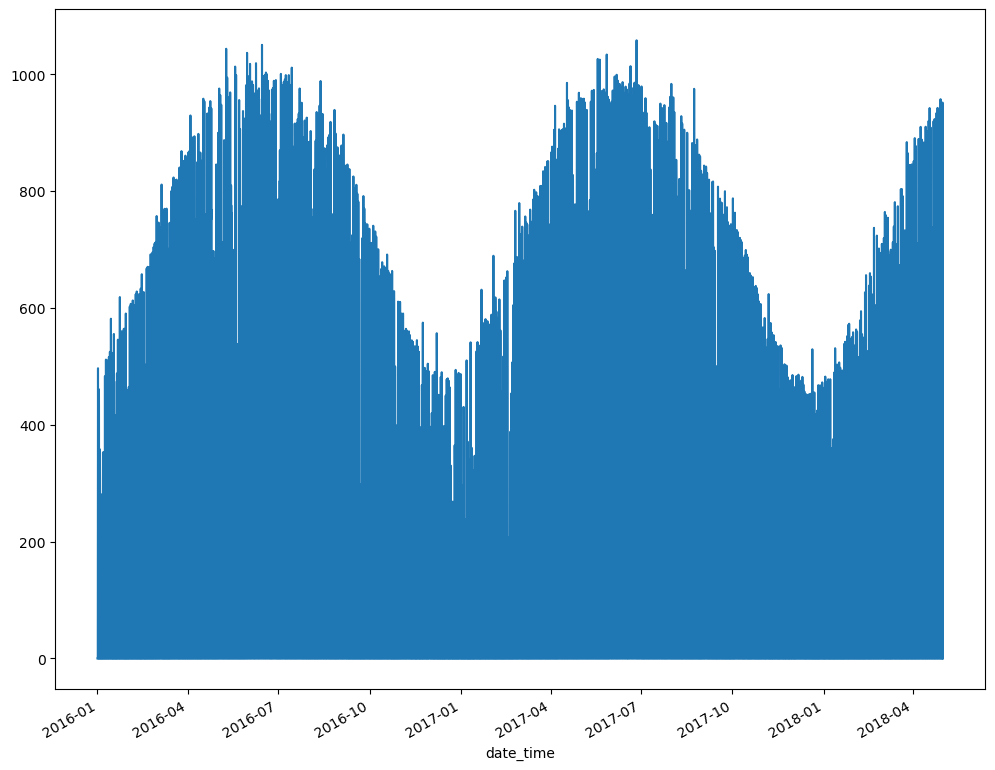

In [159]:
agrimet_hrly['solarmj'].loc[1266804].plot()

In [156]:
df = nldas.groupby(['stationid','Timestamp']).mean(numeric_only=True)['sw']
df = df[df.index.get_level_values(0).isin(agrimet_hrly.index.get_level_values(0))].reset_index().rename(columns={'Timestamp':'date_time'}).set_index(['stationid','date_time'])
pd.concat([agrimet_hrly['solarmj'],df])

0   sw
        date_time                    
1266804 2016-01-01 00:00:00  0.0  NaN
        2016-01-01 01:00:00  0.0  NaN
        2016-01-01 02:00:00  0.0  NaN
        2016-01-01 03:00:00  0.0  NaN
        2016-01-01 04:00:00  0.0  NaN
...                          ...  ...
1266807 2023-11-21 08:00:00  NaN  0.0
        2023-11-21 09:00:00  NaN  0.0
        2023-11-21 10:00:00  NaN  0.0
        2023-11-21 11:00:00  NaN  0.0
        2023-11-21 12:00:00  NaN  0.0

[485724 rows x 2 columns]

ValueError: cannot handle a non-unique multi-index!

In [122]:
studystats.index = studystats.index.astype(int)

In [125]:
df['precip_est']

date_time
2018-01-01 01:00:00    0.00
2018-01-01 02:00:00    0.00
2018-01-01 03:00:00    0.00
2018-01-01 04:00:00    0.01
2018-01-01 05:00:00    0.00
                       ... 
2023-11-24 06:00:00    0.00
2023-11-24 07:00:00    0.00
2023-11-24 08:00:00    0.01
2023-11-24 09:00:00    0.00
2023-11-24 10:00:00    0.00
Name: precip_est, Length: 82043, dtype: float64

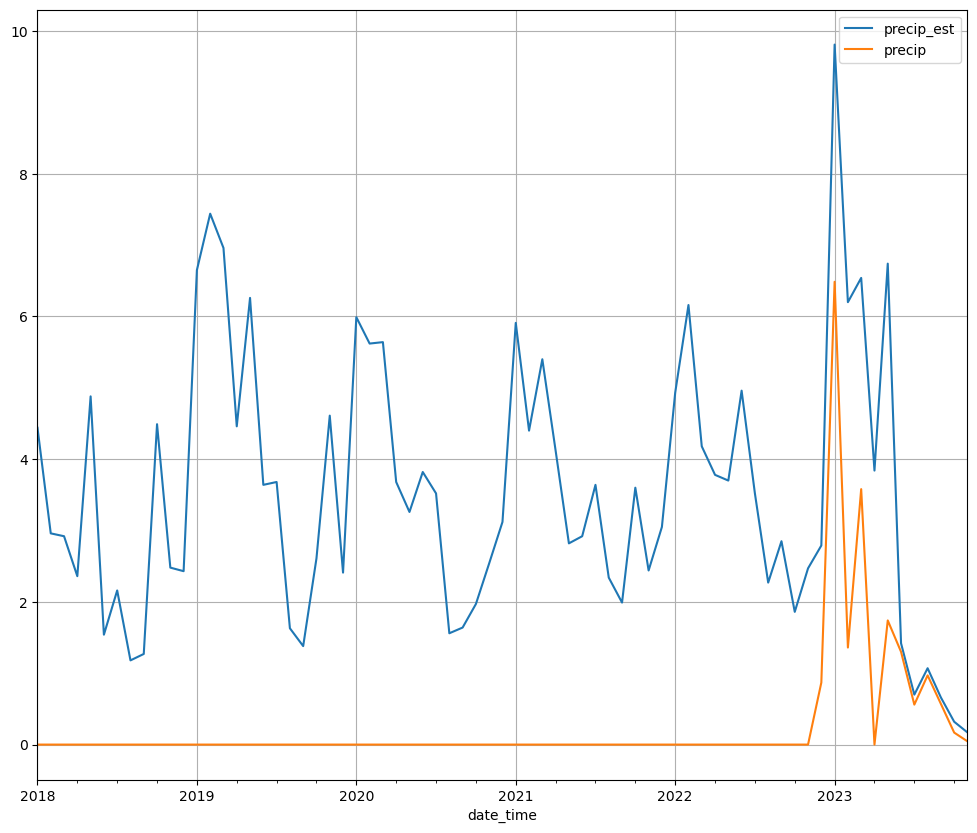

In [127]:
agstationdata.reset_index().columns
agstationdata['precip_est'] = agstationdata['precip_accum'].diff()
agstationdata['precip_est'] = agstationdata['precip_est'].clip(lower=0)

df = agstationdata.loc[1266807]
df = df[df.index >pd.to_datetime('2018-01-01')][['precip_est','precip']]

df = df.resample('1MS').sum()
df['precip_est'] = df['precip_est']#-1.5
df.plot()
plt.grid()

<Axes: xlabel='date_time'>

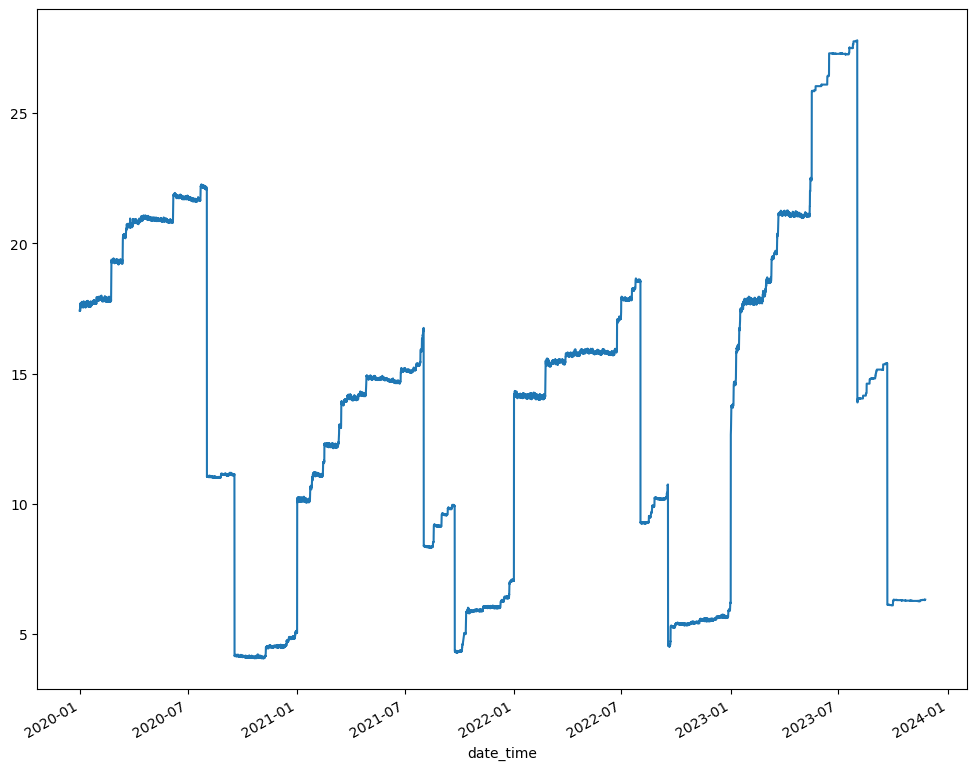

In [113]:
ag_dly = agstationdata.reset_index().rename(columns={'level_0':'station_id'})[['station_id','date_time', 'eto', 'etr', 'precip_accum','precip','eto_asce', 'etr_asce']].groupby(['station_id','date_time']).sum()
df = ag_dly.loc[1266807]
df = df[df.index >pd.to_datetime('2020-01-01')]['precip_accum']
df.plot()

1266805 0
1266807 1
1266806 2
1266804 3


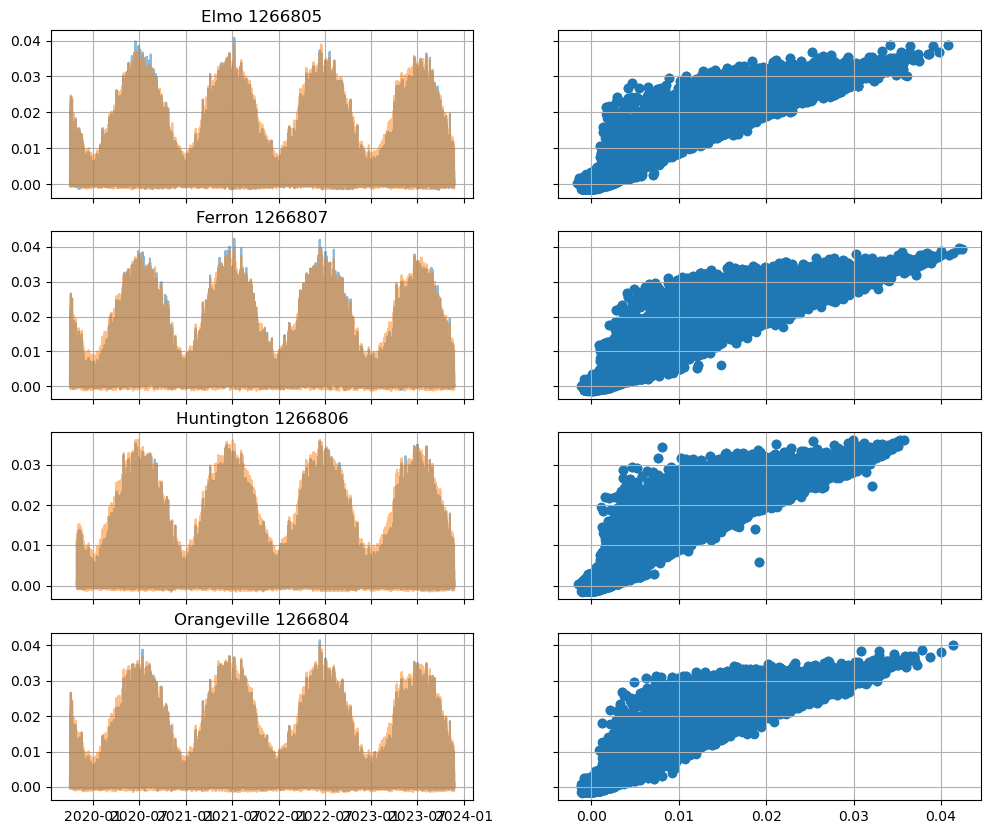

In [110]:
fig, ax = plt.subplots(4,2, sharey= 'row',sharex='col')
i = 0
for id in agstationdata.index.get_level_values(0).unique():
    print(id, i)
    station_name = studystats.loc[int(id),'name']
    df = agstationdata.loc[id]
    df = df[df.index >pd.to_datetime('2018-01-01')]
    df = df[['eto','eto_asce']].dropna()
    ax[i,0].plot(df.index, df['eto'],alpha=0.5)
    ax[i,0].plot(df.index, df['eto_asce'],alpha=0.5)
    ax[i,0].grid()
    ax[i,1].grid()
    ax[i,1].scatter(df['eto'],df['eto_asce'])
    ax[i,0].set_title(f"{station_name} {id}")
    i+=1
    

    

Text(0, 0.5, 'Monthly Reference ET (in/mo)')

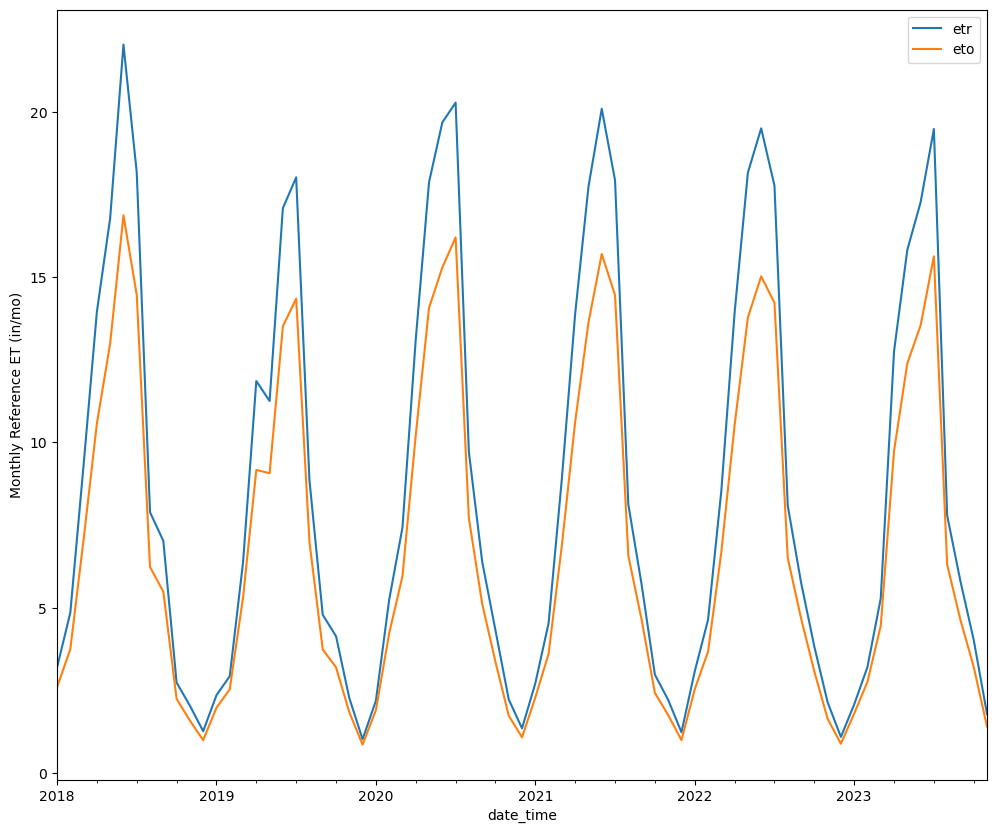

In [74]:
elmo = agstationdata.loc['1266805',['etr','eto']].groupby(pd.Grouper(level=0,freq='1M')).sum()
elmo.loc['2018-01-01':].plot()
plt.ylabel('Monthly Reference ET (in/mo)')

In [21]:
snotel.set_index(['station_id','Date'])

Snow Water Equivalent (in) Start of Day Values  \
station_id Date                                                         
714        2016-04-14                                             5.7   
           2016-04-15                                             5.4   
           2016-04-16                                             5.4   
           2016-04-17                                             5.0   
           2016-04-18                                             4.9   
...                                                               ...   
1228       2023-11-18                                             0.0   
           2023-11-19                                             0.0   
           2023-11-20                                             0.2   
           2023-11-21                                             0.1   
           2023-11-22                                             0.2   

                       Snow Depth (in) Start of Day Values  \
station_id Date                                              
714        2016-04-14                                   15   
           2016-04-15                                   15   
           2016-04-16                                   15   
           2016-04-17                                   14   
           2016-04-18                                   13   
...                                                    ...   
1228       2023-11-18                                    0   
           2023-11-19                                    0   
           2023-11-20                                    2   
           2023-11-21                                    0   
           2023-11-22                                    1   

                       Precipitation Accumulation (in) Start of Day Values  \
station_id Date                                                              
714        2016-04-14                                               15.9     
           2016-04-15                                               16.1     
           2016-04-16                                               16.1     
           2016-04-17                                               16.1     
           2016-04-18                                               16.1     
...                                                                  ...     
1228       2023-11-18                                                1.2     
           2023-11-19                                                1.2     
           2023-11-20                                                1.4     
           2023-11-21                                                1.5     
           2023-11-22                                                1.5     

                       Air Temperature Observed (degF) Start of Day Values  \
station_id Date                                                              
714        2016-04-14                                               38.1     
           2016-04-15                                               24.8     
           2016-04-16                                               25.7     
           2016-04-17                                               26.2     
           2016-04-18                                               19.9     
...                                                                  ...     
1228       2023-11-18                                               31.3     
           2023-11-19                                               32.4     
           2023-11-20                                               23.2     
           2023-11-21                                               16.5     
           2023-11-22                                               23.4     

                       Air Temperature Maximum (degF)  \
station_id Date                                         
714        2016-04-14                            50.2   
           2016-04-15                            38.3   
        

<table class="dd-table mdl-data-table mdl-js-data-table" data-upgraded=",MaterialDataTable"><thead><tr><th class="mdl-data-table__cell--non-numeric"> Name </th><th class="mdl-data-table__cell--non-numeric"> Description </th><th> Min* </th><th> Max* </th> <th> Units </th> </tr></thead><tbody><tr><td class="mdl-data-table__cell--non-numeric"> pr </td><td class="mdl-data-table__cell--non-numeric"> Precipitation amount </td><td> 0 </td><td> 690.44 </td><td> mm, daily total </td></tr><tr><td class="mdl-data-table__cell--non-numeric"> rmax </td><td class="mdl-data-table__cell--non-numeric"> Maximum relative humidity </td><td> 1.05 </td><td> 100 </td><td> % </td></tr><tr><td class="mdl-data-table__cell--non-numeric"> rmin </td><td class="mdl-data-table__cell--non-numeric"> Minimum relative humidity </td><td> 0 </td><td> 100 </td><td> % </td></tr><tr><td class="mdl-data-table__cell--non-numeric"> sph </td><td class="mdl-data-table__cell--non-numeric"> Specific humididy </td><td> 0 </td><td> 0.02 </td><td> Mass fraction </td></tr><tr><td class="mdl-data-table__cell--non-numeric"> srad </td><td class="mdl-data-table__cell--non-numeric"> Surface downward shortwave radiation </td><td> 0 </td><td> 455.61 </td><td> W/m^2 </td></tr><tr><td class="mdl-data-table__cell--non-numeric"> th </td><td class="mdl-data-table__cell--non-numeric"> Wind direction </td><td>  </td><td>  </td><td> deg </td></tr><tr><td class="mdl-data-table__cell--non-numeric"> tmmn </td><td class="mdl-data-table__cell--non-numeric"> Minimum temperature </td><td> 225.54 </td><td> 314.88 </td><td> K </td></tr><tr><td class="mdl-data-table__cell--non-numeric"> tmmx </td><td class="mdl-data-table__cell--non-numeric"> Maximum temperature </td><td> 233.08 </td><td> 327.14 </td><td> K </td></tr><tr><td class="mdl-data-table__cell--non-numeric"> vs </td><td class="mdl-data-table__cell--non-numeric"> Wind velocity at 10m </td><td> 0.14 </td><td> 29.13 </td><td> m/s </td></tr><tr><td class="mdl-data-table__cell--non-numeric"> erc </td><td class="mdl-data-table__cell--non-numeric"> Energy release component </td><td> 0 </td><td> 131.85 </td><td> NFDRS fire danger index </td></tr><tr><td class="mdl-data-table__cell--non-numeric"> eto </td><td class="mdl-data-table__cell--non-numeric"> Daily grass reference evapotranspiration </td><td> 0 </td><td> 17.27 </td><td> mm </td></tr><tr><td class="mdl-data-table__cell--non-numeric"> bi </td><td class="mdl-data-table__cell--non-numeric"> Burning index </td><td> 0 </td><td> 214.2 </td><td> NFDRS fire danger index </td></tr><tr><td class="mdl-data-table__cell--non-numeric"> fm100 </td><td class="mdl-data-table__cell--non-numeric"> 100-hour dead fuel moisture </td><td> 0.28 </td><td> 33.2 </td><td> % </td></tr><tr><td class="mdl-data-table__cell--non-numeric"> fm1000 </td><td class="mdl-data-table__cell--non-numeric"> 1000-hour dead fuel moisture </td><td> 0.36 </td><td> 47.52 </td><td> % </td></tr><tr><td class="mdl-data-table__cell--non-numeric"> etr </td><td class="mdl-data-table__cell--non-numeric"> Daily alfalfa reference evapotranspiration </td><td> 0 </td><td> 27.02 </td><td> mm </td></tr><tr><td class="mdl-data-table__cell--non-numeric"> vpd </td><td class="mdl-data-table__cell--non-numeric"> Mean vapor pressure deficit </td><td> 0 </td><td> 9.83 </td><td> kPa </td></tr></tbody></table>